In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.model_selection import KFold

c:\Users\Randell\anaconda3\envs\tf_env\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\Randell\anaconda3\envs\tf_env\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.

In [2]:
#Data reading
df = pd.read_csv("worldcoin-org_2019-06-19_2024-06-17.csv")
df

,Start,End,Open,High,Low,Close,Volume,Market Cap
0,2024-06-16,2024-06-17,435.434564,450.283266,424.506973,444.698612,3.149406e+10,9.786989e+10
1,2024-06-15,2024-06-16,442.207514,450.754333,433.511423,435.805905,4.558511e+10,9.913209e+10
2,2024-06-14,2024-06-15,471.470823,479.991323,431.186058,442.021938,4.505473e+10,1.028360e+11
3,2024-06-13,2024-06-14,494.564923,500.807162,466.376275,468.211321,5.922474e+10,1.073532e+11
4,2024-06-12,2024-06-13,489.541653,526.686680,469.800441,497.223618,7.096327e+10,1.118204e+11
...,...,...,...,...,...,...,...,...
324,2023-07-28,2023-07-29,266.303801,286.533403,264.554328,285.644185,6.007178e+10,2.919856e+10
325,2023-07-27,2023-07-28,287.676920,295.834139,268.693036,269.989743,9.477407e+10,2.970630e+10
326,2023-07-26,2023-07-27,293.852710,321.444574,282.445740,289.173453,1.894057e+11,3.163373e+10
327,2023-07-25,2023-07-26,278.619394,309.644293,245.956788,293.075495,1.737368e+11,2.890207e+10


In [3]:
#convert Start and End columns to datetime
df["Start"] = pd.to_datetime(df["Start"])
df["End"] = pd.to_datetime(df["End"])

In [4]:
#Features and target variable
X = df[["Open", "High", "Low", "Volume", "Market Cap"]]
y = df["Close"]

In [5]:
#Splitting data to train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
#Scale the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
# Increase Model Complexity
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

optimizer = tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=1e-4)
model.compile(optimizer=optimizer, loss='mse')

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', verbose=1)

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=200, batch_size=32, 
                    validation_split=0.2, verbose=1, 
                    callbacks=[lr_scheduler, early_stopping, checkpoint])

Epoch 1/200
1/7 [===>..........................] - ETA: 4s - loss: 355299.1562
Epoch 1: val_loss improved from inf to 348791.12500, saving model to best_model.h5
7/7 [==============================] - 1s 63ms/step - loss: 300338.5625 - val_loss: 348791.1250 - lr: 0.0010
Epoch 2/200
1/7 [===>..........................] - ETA: 0s - loss: 371129.0625
Epoch 2: val_loss improved from 348791.12500 to 348594.15625, saving model to best_model.h5
7/7 [==============================] - 0s 16ms/step - loss: 300204.0625 - val_loss: 348594.1562 - lr: 0.0010
Epoch 3/200
1/7 [===>..........................] - ETA: 0s - loss: 293907.7500
Epoch 3: val_loss improved from 348594.15625 to 348118.53125, saving model to best_model.h5
7/7 [==============================] - 0s 16ms/step - loss: 299937.6875 - val_loss: 348118.5312 - lr: 0.0010
Epoch 4/200
1/7 [===>..........................] - ETA: 0s - loss: 378031.4688
Epoch 4: val_loss improved from 348118.53125 to 346949.06250, saving model to best_model.h

In [8]:
# Ensure X_train_scaled and y_train are NumPy arrays
X_train_scaled = np.array(X_train_scaled)
y_train = np.array(y_train)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
val_scores = []

for train_index, val_index in kfold.split(X_train_scaled):
    X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    
    optimizer = tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=1e-4)
    model.compile(optimizer=optimizer, loss='mse')
    
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6, verbose=1)
    early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, verbose=1)
    checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', verbose=1)
    
    history = model.fit(X_train_fold, y_train_fold, epochs=200, batch_size=32, 
                        validation_data=(X_val_fold, y_val_fold), verbose=1, 
                        callbacks=[lr_scheduler, early_stopping, checkpoint])
    
    val_loss = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    val_scores.append(val_loss)

print(f'Validation MSE scores for each fold: {val_scores}')
print(f'Mean Validation MSE: {np.mean(val_scores)}')

Epoch 1/200
1/7 [===>..........................] - ETA: 4s - loss: 267519.3750
Epoch 1: val_loss improved from inf to 287493.62500, saving model to best_model.h5
7/7 [==============================] - 1s 55ms/step - loss: 315652.8125 - val_loss: 287493.6250 - lr: 0.0010
Epoch 2/200
1/7 [===>..........................] - ETA: 0s - loss: 325107.8750
Epoch 2: val_loss improved from 287493.62500 to 286941.65625, saving model to best_model.h5
7/7 [==============================] - 0s 16ms/step - loss: 315260.3438 - val_loss: 286941.6562 - lr: 0.0010
Epoch 3/200
1/7 [===>..........................] - ETA: 0s - loss: 316664.0625
Epoch 3: val_loss improved from 286941.65625 to 285607.96875, saving model to best_model.h5
7/7 [==============================] - 0s 16ms/step - loss: 314464.4062 - val_loss: 285607.9688 - lr: 0.0010
Epoch 4/200
1/7 [===>..........................] - ETA: 0s - loss: 319421.3750
Epoch 4: val_loss improved from 285607.96875 to 282524.87500, saving model to best_model.h

3/3 [==============================] - 0s 4ms/step


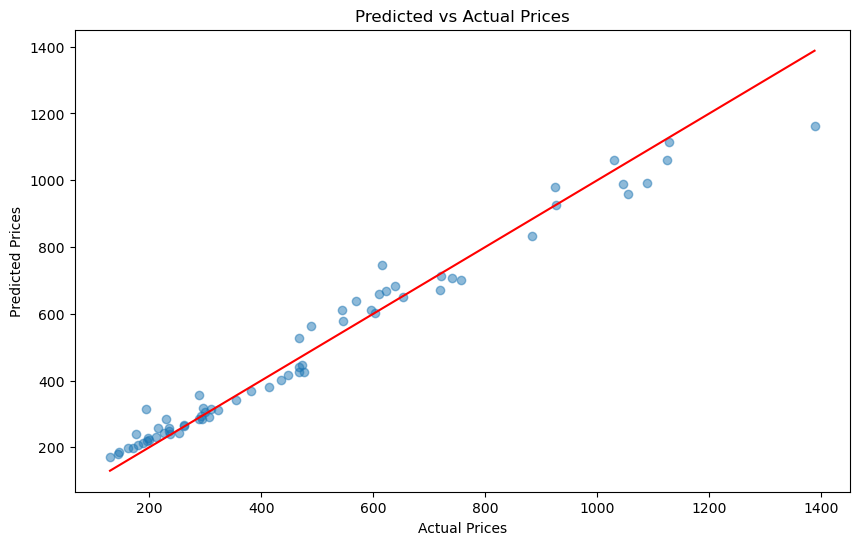

In [9]:
# Load the best weights
model.load_weights('best_model.h5')

# Assuming you have X_test_scaled and y_test as your test dataset
# Replace these with your actual test datasets
X_test_scaled = np.array(X_test_scaled)
y_test = np.array(y_test)

# Predict the prices on the test set
y_pred = model.predict(X_test_scaled)

# Plot Predicted vs Actual Prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Diagonal line
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Predicted vs Actual Prices')
plt.show()

In [10]:
# Save the model
model.save('trained_model.h5')